# Fractional gas and pricing anchors

#### Maria Silva, October 2025

Glamsterdam is planned to include many EIPs that reprice EVM operations, e.g., EIP-2780, EIP-7904, EIP-8037, and EIP-8038. This is the perfect opportunity for standardizing the gas costs of EVM operations. A key challenge for this the choice of a price anchor, i.e., how to convert resource utilization into a standardized gas cost.

Independent of the final choice, the anchor will induce a specific million gas per second rate on compute and state access operations. For instance, if we anchor on `EcRecover` at the current price (3000 gas units), this induces a rate of 175Mgas/s. So, it is easier to simply think of all anchors in terms of Mgas/s.

Given that the current gas model uses integer gas units, there is a trade-off in choice of an anchor - with higher Mgas/s, we get more expressive prices as the rounding error are lower. However, this comes at the cost of all operations becoming more expensive, which means that we will have to raise more the gas limit to process the same amount of transactions. This also means we need to further raise the cost of other resources such as state and data to make the relative costs between resources more balanced. This will likely be a harder change for end-users.

In this notebook we explore this trade-off and how using fractional gas could help mitigate it.

## Load data and libraries

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# plotting theme
sns.set_theme(
    style="whitegrid", palette="Set2", rc={"figure.dpi": 500, "axes.titlesize": 15}
)

In [3]:
# Main directories
current_path = os.getcwd()
repo_dir = os.path.abspath(os.path.join(current_path, ".."))
data_dir = os.path.join(repo_dir, "data")

This data was taken directly from the [EIP's additional files](https://github.com/ethereum/EIPs/blob/master/assets/eip-7904/final_gas_schedule_comparison.csv).

In [4]:
df = pd.read_csv(os.path.join(data_dir, "final_gas_schedule_comparison.csv"))
df = df.drop(columns=["ethereumjs_gas", "ethereumjs_gas_stderr", "evmone_gas", "evmone_gas_stderr"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   besu_gas                    167 non-null    float64
 1   besu_gas_stderr             167 non-null    float64
 2   erigon_gas                  166 non-null    float64
 3   erigon_gas_stderr           166 non-null    float64
 4   geth_gas                    166 non-null    float64
 5   geth_gas_stderr             166 non-null    float64
 6   nethermind_gas              166 non-null    float64
 7   nethermind_gas_stderr       166 non-null    float64
 8   revm_gas                    154 non-null    float64
 9   revm_gas_stderr             154 non-null    float64
 10  opcode                      167 non-null    object 
 11  constant_current_gas        167 non-null    float64
 12  alternative_gas             167 non-null    float64
 13  alternative_gas_stderr      167 non

In [5]:
client_gas_cols = [c for c in df.columns[:9] if c.endswith("_gas")]

param_df = df.melt(
    id_vars=["opcode"],
    value_vars=[c for c in df.columns[:9] if c.endswith("_gas")],
    var_name="client",
    value_name="param_ns",
)
param_df["client"] = param_df["client"].str.replace("_gas", "")
param_df

,opcode,client,param_ns
0,ADD,besu,7.171282e+00
1,MUL,besu,8.143532e+00
2,SUB,besu,6.806273e+00
3,DIV,besu,5.826503e+00
4,SDIV,besu,6.676850e+00
...,...,...,...
830,CREATE_ARG2,revm,NaN
831,RETURN_ARG1,revm,8.161624e-07
832,REVERT_ARG1,revm,-2.120710e-06
833,RIPEMD-160_ARG1,revm,2.212405e-06


Now, let's filter only the pure compute & memory operations and precompiles (for simplicity) and get the worse timings for each operation.

In [6]:
with open(os.path.join(data_dir, "compute_ops.txt"), "r") as f:
    compute_ops_list = f.read().splitlines()
compute_ops_list = [op for op in compute_ops_list if ("#" not in op) and (op != "")]
compute_ops_list = [op.split(" = ")[0] for op in compute_ops_list]

with open(os.path.join(data_dir, "mem_ops.txt"), "r") as f:
    memory_ops_list = f.read().splitlines()
memory_ops_list = [op for op in memory_ops_list if ("#" not in op) and (op != "")]
memory_ops_list = [op.split(" = ")[0] for op in memory_ops_list]

precomp_list = [
    "ECRECOVER",
    "SHA2-256",
    "RIPEMD-160",
    "IDENTITY",
    "MODEXP",
    "ECADD",
    "ECMUL",
    "ECPAIRING79000",
    "ECPAIRING113000",
    "ECPAIRING181000",
    "ECPAIRING317000",
    "BLAKE2F",
]

In [7]:
worse_df = (
    param_df[param_df["opcode"].isin(compute_ops_list+precomp_list+memory_ops_list)]
    .dropna()
    .sort_values("param_ns")
    .groupby("opcode")
    .last()
    .reset_index()
    .drop(columns=["client"])
)
worse_df

,opcode,param_ns
0,ADD,7.171282
1,ADDMOD,25.502540
2,ADDRESS,7.997121
3,AND,3.857343
4,BLAKE2F,258.113508
...,...,...
130,SWAP9,5.524204
131,TIMESTAMP,2.542497
132,TLOAD,28.607564
133,TSTORE,83.060644


## 60Mgas/s anchor example

In [8]:
anchor_rate = 60*1e6

new_gas_df = worse_df.copy()
new_gas_df["new_gas"] = (anchor_rate*new_gas_df["param_ns"])/1e9
new_gas_df["new_gas_rounded"] = new_gas_df["new_gas"].round().astype(int)
new_gas_df["new_gas_rounded"] = np.where(
    new_gas_df["new_gas_rounded"] == 0, 1, new_gas_df["new_gas_rounded"]
)
new_gas_df["rounding_error"] = new_gas_df["new_gas_rounded"] - new_gas_df["new_gas"]
new_gas_df["rounding_error_rate"] = new_gas_df["rounding_error"]/new_gas_df["new_gas_rounded"]
new_gas_df

,opcode,param_ns,new_gas,new_gas_rounded,rounding_error,rounding_error_rate
0,ADD,7.171282,0.430277,1,0.569723,0.569723
1,ADDMOD,25.502540,1.530152,2,0.469848,0.234924
2,ADDRESS,7.997121,0.479827,1,0.520173,0.520173
3,AND,3.857343,0.231441,1,0.768559,0.768559
4,BLAKE2F,258.113508,15.486810,15,-0.486810,-0.032454
...,...,...,...,...,...,...
130,SWAP9,5.524204,0.331452,1,0.668548,0.668548
131,TIMESTAMP,2.542497,0.152550,1,0.847450,0.847450
132,TLOAD,28.607564,1.716454,2,0.283546,0.141773
133,TSTORE,83.060644,4.983639,5,0.016361,0.003272


In [9]:
new_gas_df[new_gas_df["opcode"] == "ECRECOVER"]

,opcode,param_ns,new_gas,new_gas_rounded,rounding_error,rounding_error_rate
38,ECRECOVER,17191.023993,1031.46144,1031,-0.46144,-0.000448


Ok, let's see the distribution of rounding error rates per operation:

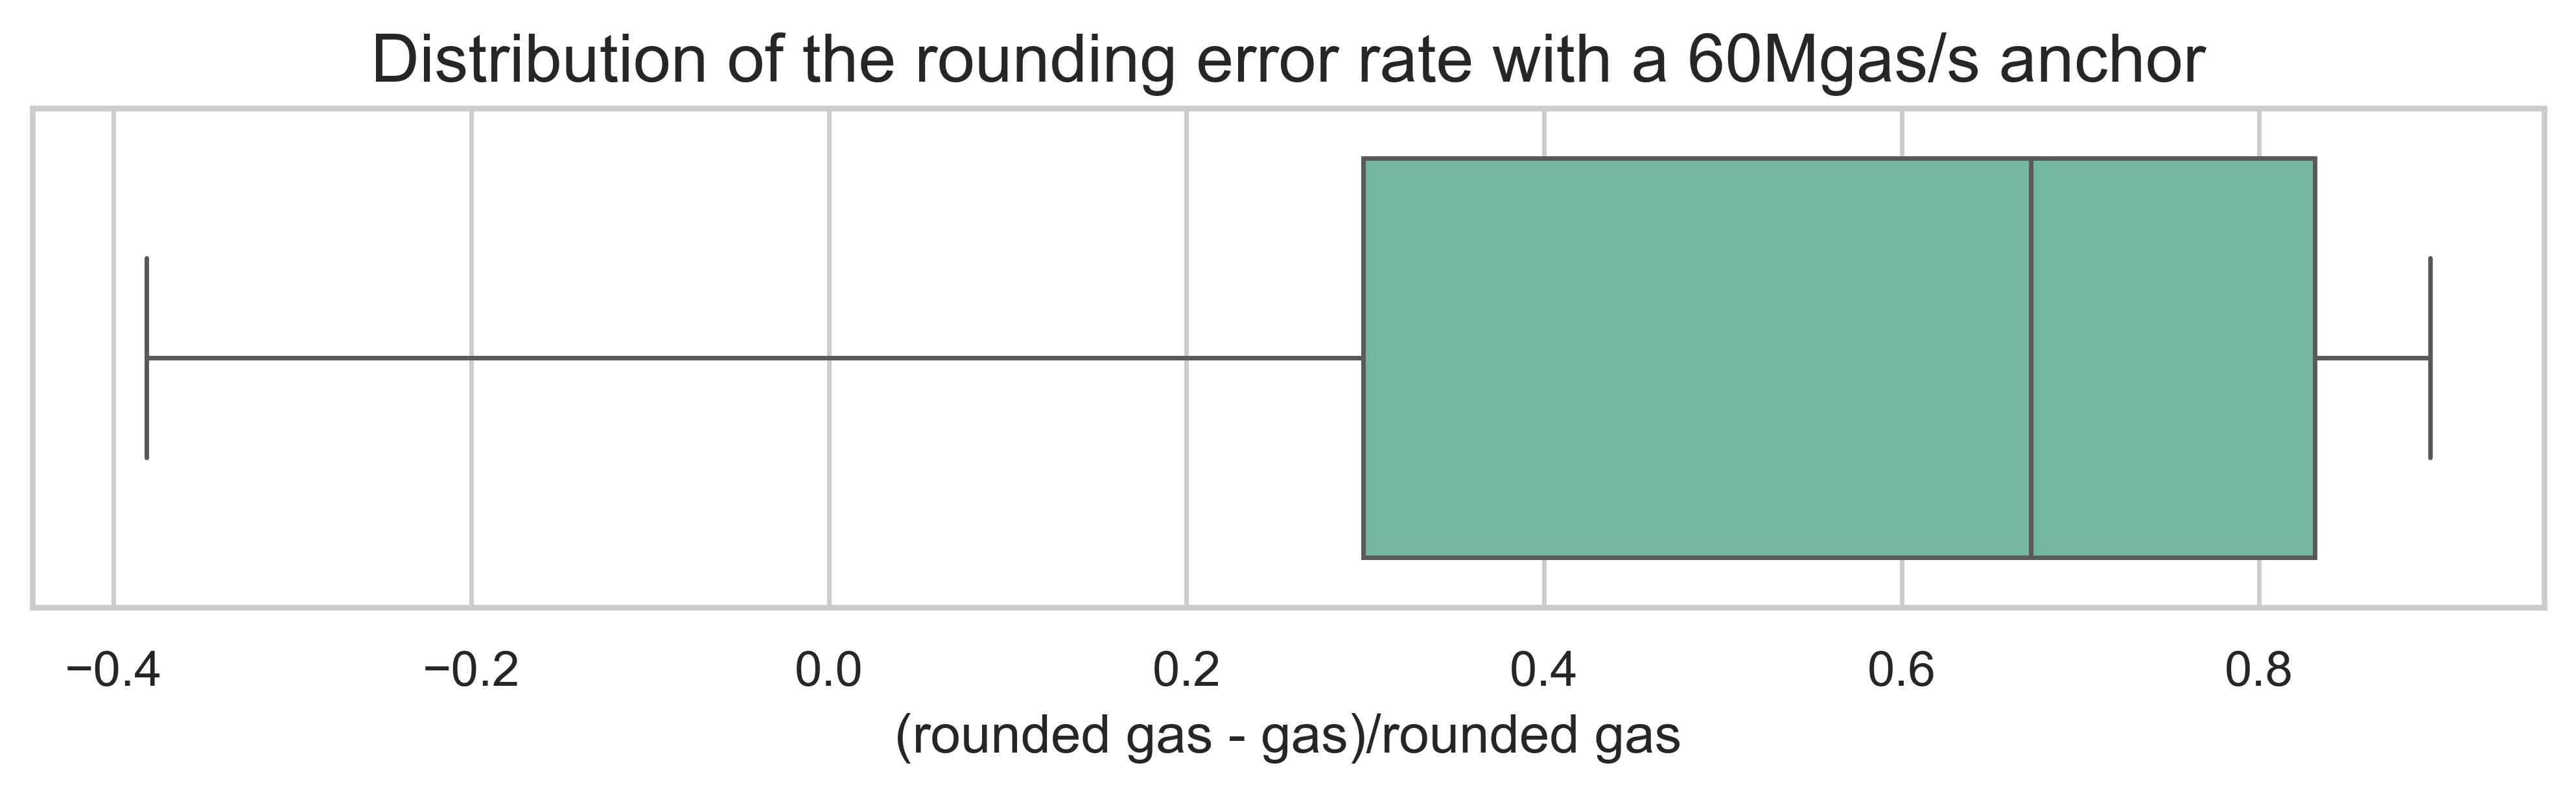

In [10]:
plt.figure(figsize=(10, 2))
sns.boxplot(
    data=new_gas_df,
    x="rounding_error_rate"
)

plt.title("Distribution of the rounding error rate with a 60Mgas/s anchor")
plt.ylabel("")
plt.xlabel("(rounded gas - gas)/rounded gas")
plt.show()

In [11]:
new_gas_df["rounding_error_rate"].agg(["mean", "std", "median"])

mean      0.549440
std       0.323200
median    0.672257
Name: rounding_error_rate, dtype: float64

So, on average, with a 60Mgas/s anchor, operations have a rounding error of 54.9%. This means that we could be 54.9% cheaper on average if we didn't have to round to integer gas units.

Also, most operations are being rounded up, i.e., they become more expensive with the rounding. This is actually due to most operations having a gas cost lower than 1 gas unit with this anchor:

In [12]:
sum(new_gas_df["new_gas"]<1)/len(new_gas_df)

0.8444444444444444

## Rounding errors by anchor

In [13]:
anchor_list = [10, 50, 100, 150, 200, 300, 400, 500, 600]  # in Mgas/s
error_df = pd.DataFrame(columns=["mean", "median", "frac_below_1gas", "EcRecover_cost"], index=anchor_list)
for anchor in anchor_list:
    anchor_rate = anchor * 1e6
    new_gas_df = worse_df.copy()
    new_gas_df["new_gas"] = (anchor_rate * new_gas_df["param_ns"]) / 1e9
    new_gas_df["new_gas_rounded"] = new_gas_df["new_gas"].round().astype(int)
    new_gas_df["new_gas_rounded"] = np.where(
        new_gas_df["new_gas_rounded"] == 0, 1, new_gas_df["new_gas_rounded"]
    )
    new_gas_df["rounding_error_rate"] = (
        new_gas_df["new_gas_rounded"] - new_gas_df["new_gas"]
    ) / new_gas_df["new_gas_rounded"]
    error_df.loc[anchor] = pd.Series(
        [
            new_gas_df["rounding_error_rate"].mean(),
            new_gas_df["rounding_error_rate"].median(),
            sum(new_gas_df["new_gas"] < 1) / len(new_gas_df),
            new_gas_df[new_gas_df["opcode"] == "ECRECOVER"]["new_gas_rounded"].values[0],
        ],
        index=["mean", "median", "frac_below_1gas", "EcRecover_cost"]
    )
error_df = error_df.reset_index().rename(columns={"index": "anchor"})
error_df

,anchor,mean,median,frac_below_1gas,EcRecover_cost
0,10,0.840897,0.945376,0.911111,172.0
1,50,0.593179,0.726881,0.859259,860.0
2,100,0.373851,0.453762,0.688889,1719.0
3,150,0.253327,0.223739,0.562963,2579.0
4,200,0.179847,0.168117,0.488889,3438.0
5,300,0.047142,0.037237,0.340741,5157.0
6,400,0.002107,-0.000001,0.148148,6876.0
7,500,-0.07687,-0.019122,0.014815,8596.0
8,600,-0.041773,-0.00003,0.0,10315.0


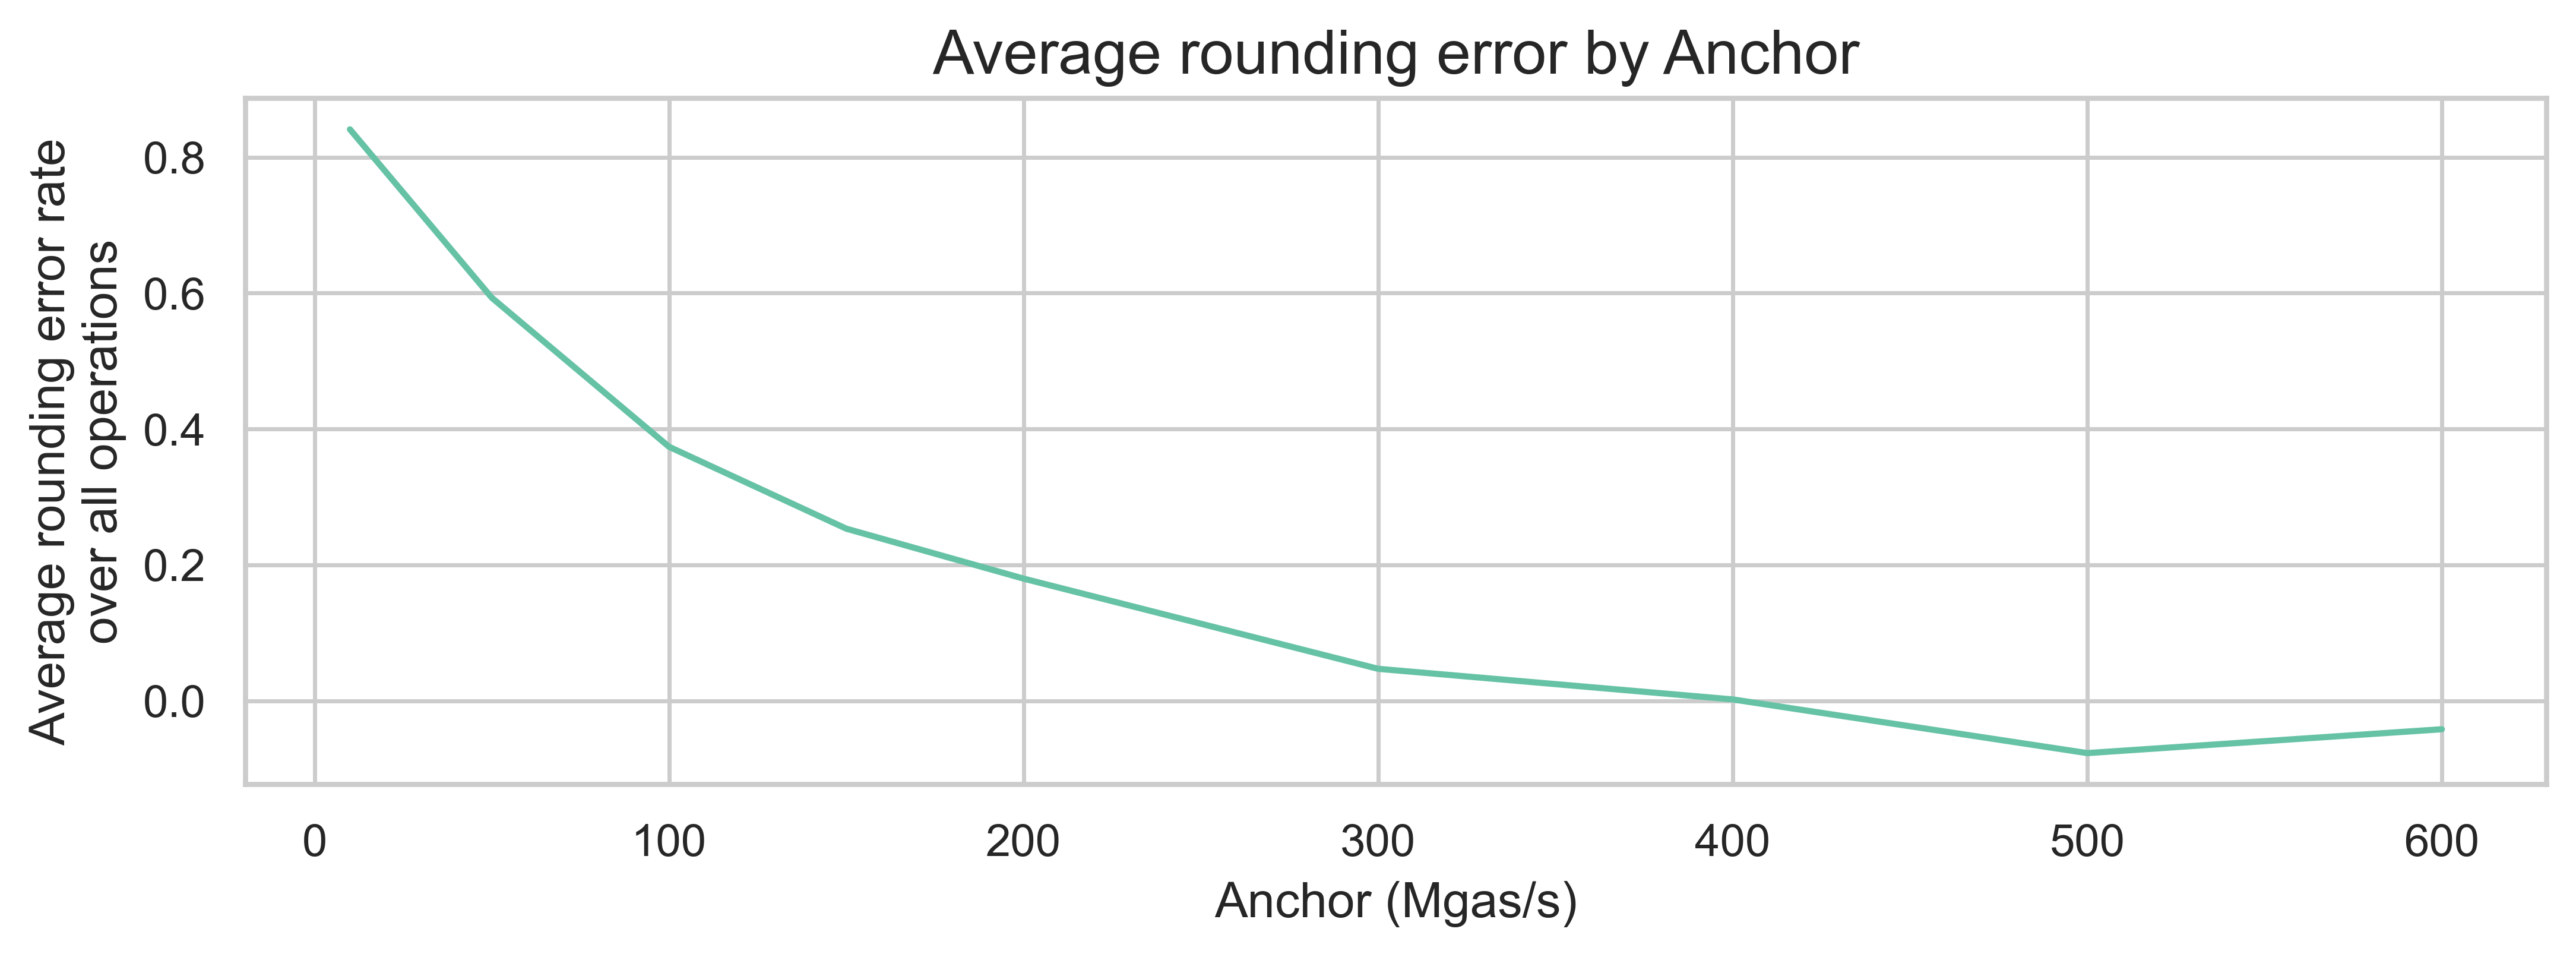

In [14]:
plt.figure(figsize=(10, 3))
sns.lineplot(error_df, x="anchor", y="mean")
plt.title("Average rounding error by Anchor")
plt.xlabel("Anchor (Mgas/s)")
plt.ylabel("Average rounding error rate\nover all operations")
plt.show()

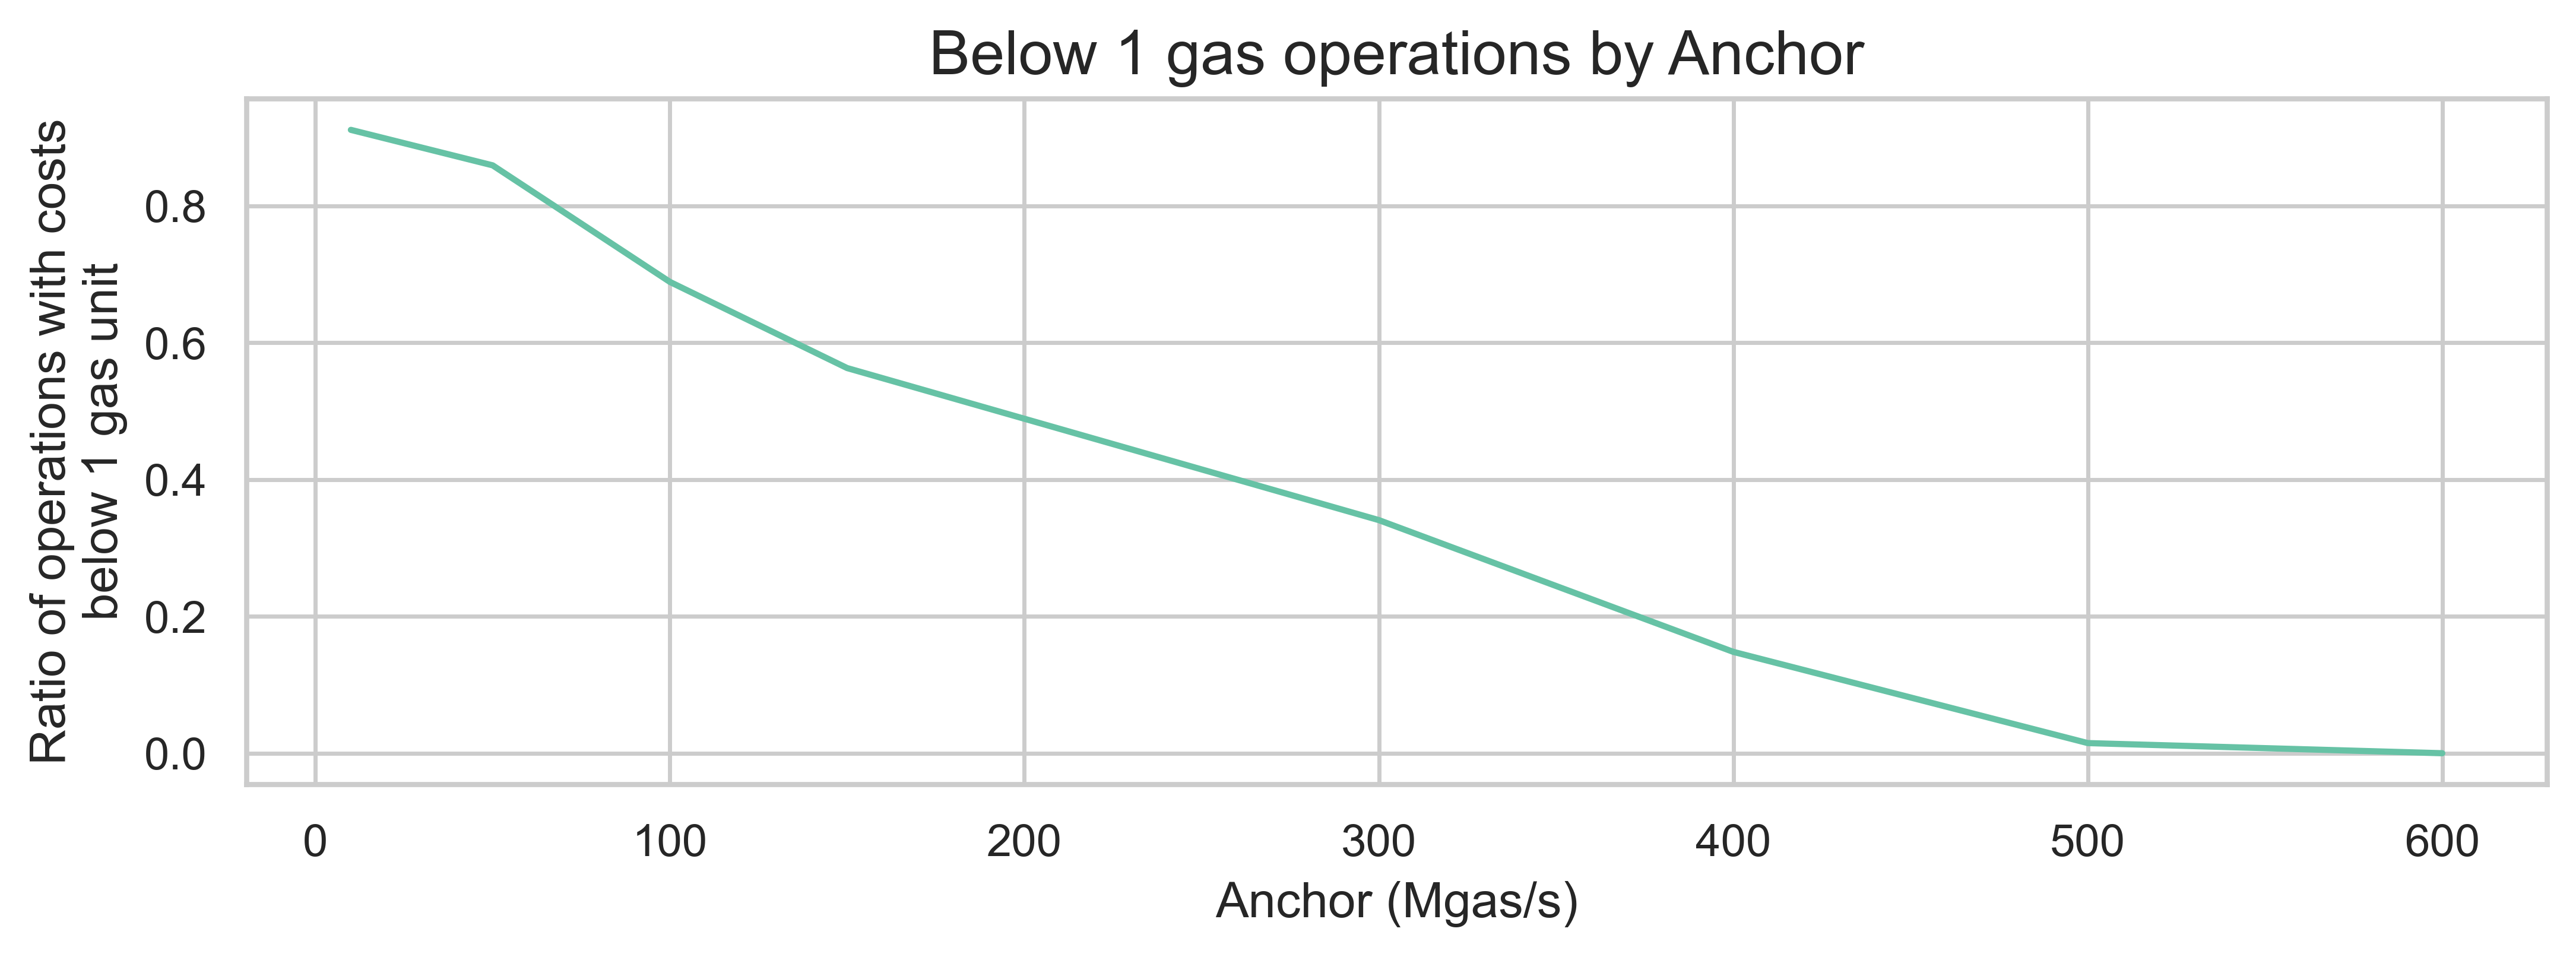

In [15]:
plt.figure(figsize=(10, 3))
sns.lineplot(error_df, x="anchor", y="frac_below_1gas")
plt.title("Below 1 gas operations by Anchor")
plt.xlabel("Anchor (Mgas/s)")
plt.ylabel("Ratio of operations with costs\nbelow 1 gas unit")
plt.show()

## Rounding errors with fractional gas

In [16]:
anchor_list = [10, 50, 100, 150, 200, 300, 400, 500, 600]  # in Mgas/s
error_frac_df = pd.DataFrame(columns=["mean", "median", "frac_below_0.1gas", "EcRecover_cost"], index=anchor_list)
for anchor in anchor_list:
    anchor_rate = anchor * 1e6
    new_gas_df = worse_df.copy()
    new_gas_df["new_gas"] = (anchor_rate * new_gas_df["param_ns"]) / 1e9
    new_gas_df["new_gas_rounded"] = new_gas_df["new_gas"].round(1)
    new_gas_df["new_gas_rounded"] = np.where(
        new_gas_df["new_gas_rounded"] == 0.0, 0.1, new_gas_df["new_gas_rounded"]
    )
    new_gas_df["rounding_error_rate"] = (
        new_gas_df["new_gas_rounded"] - new_gas_df["new_gas"]
    ) / new_gas_df["new_gas_rounded"]
    error_frac_df.loc[anchor] = pd.Series(
        [
            new_gas_df["rounding_error_rate"].mean(),
            new_gas_df["rounding_error_rate"].median(),
            sum(new_gas_df["new_gas"] < 0.1) / len(new_gas_df),
            new_gas_df[new_gas_df["opcode"] == "ECRECOVER"]["new_gas_rounded"].values[0],
        ],
        index=["mean", "median", "frac_below_0.1gas", "EcRecover_cost"]
    )
error_frac_df = error_frac_df.reset_index().rename(columns={"index": "anchor"})
error_frac_df

,anchor,mean,median,frac_below_0.1gas,EcRecover_cost
0,10,0.373851,0.453762,0.688889,171.9
1,50,-0.07687,-0.019122,0.014815,859.6
2,100,-0.003284,0.002104,0.0,1719.1
3,150,-0.005593,0.0,0.0,2578.7
4,200,0.002578,0.000641,0.0,3438.2
5,300,0.003212,0.000138,0.0,5157.3
6,400,-0.001409,-0.00092,0.0,6876.4
7,500,-0.000078,0.00036,0.0,8595.5
8,600,-0.000608,-0.000043,0.0,10314.6


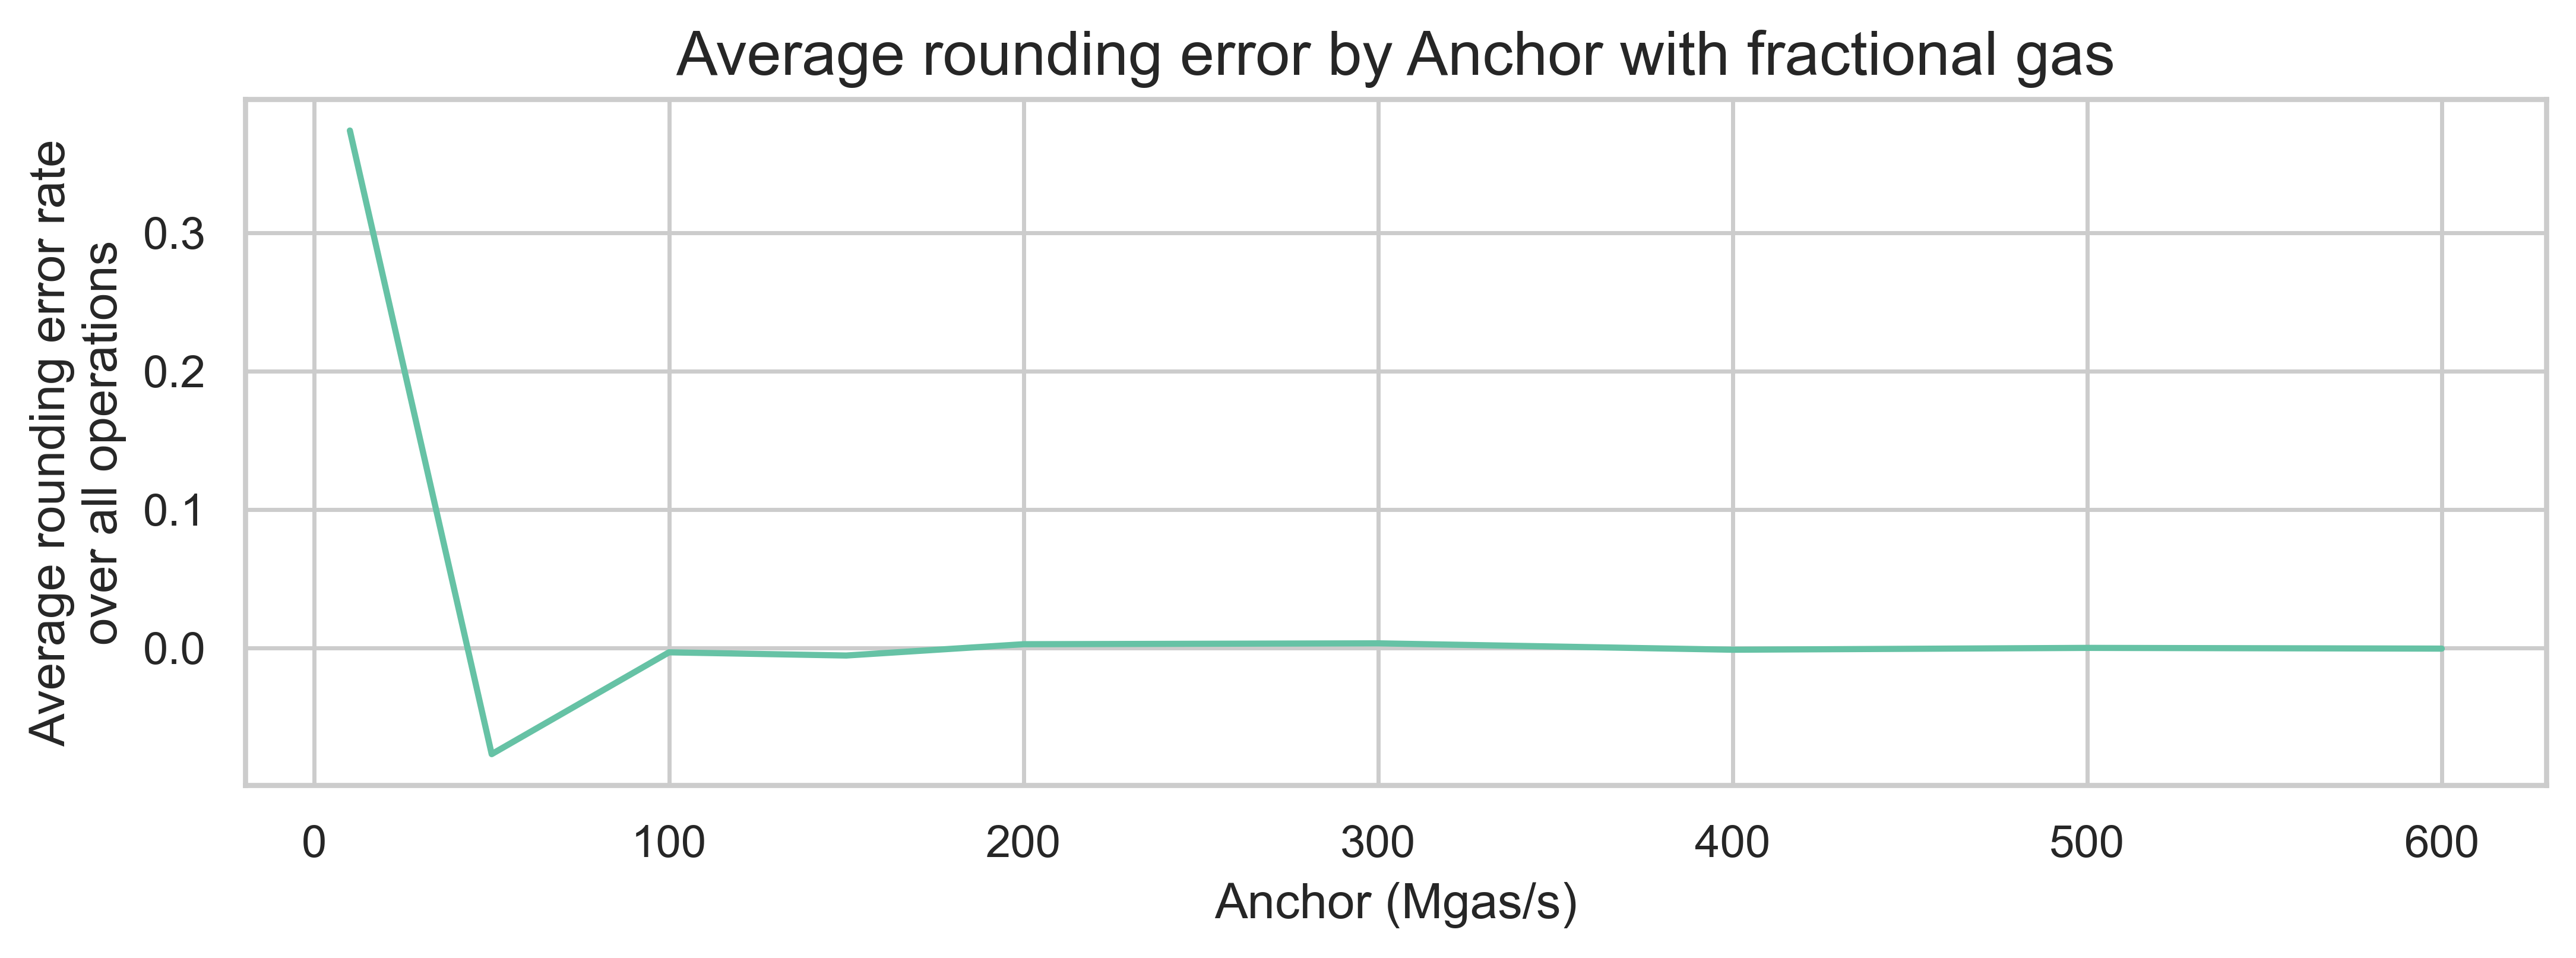

In [17]:
plt.figure(figsize=(10, 3))
sns.lineplot(error_frac_df, x="anchor", y="mean")
plt.title("Average rounding error by Anchor with fractional gas")
plt.xlabel("Anchor (Mgas/s)")
plt.ylabel("Average rounding error rate\nover all operations")
plt.show()

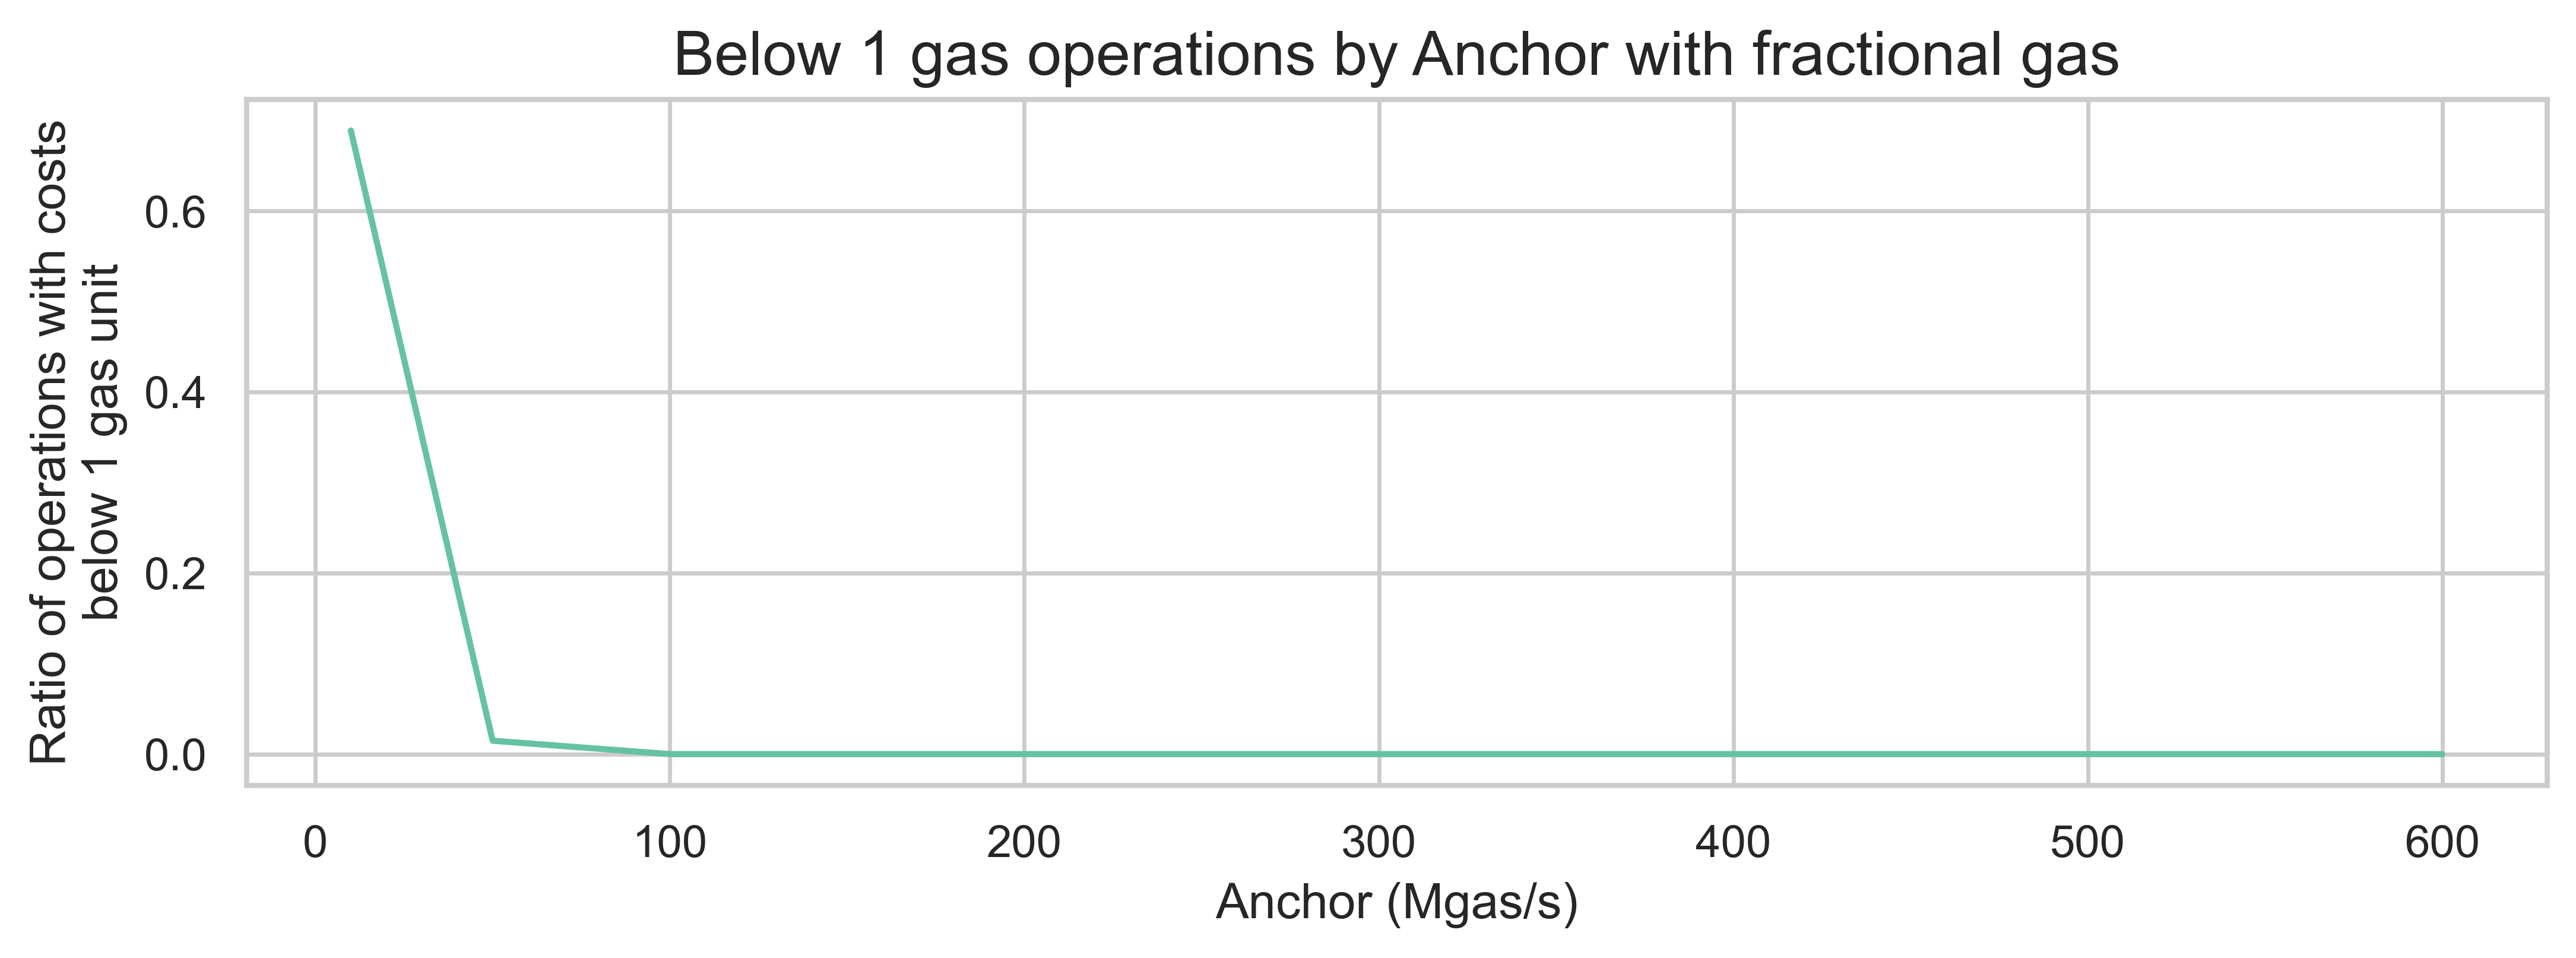

In [18]:
plt.figure(figsize=(10, 3))
sns.lineplot(error_frac_df, x="anchor", y="frac_below_0.1gas")
plt.title("Below 1 gas operations by Anchor with fractional gas")
plt.xlabel("Anchor (Mgas/s)")
plt.ylabel("Ratio of operations with costs\nbelow 1 gas unit")
plt.show()

## Rebasing gas for rounding errors

Now we are assuming the fastest operation costs 5 gas (which should remove most of the rounding errors) and we compute the costs of all other operations based on this anchor.

In [19]:
worse_df.sort_values("param_ns").head(1)

,opcode,param_ns
48,JUMPDEST,1.741227


Translating the execution time of the fastest opcode for the worse client to Mgas/s we get:

In [20]:
fastest_param = worse_df["param_ns"].min()
print("Fastest opcode execution time:", round(fastest_param, 1), "ns")
print("Fastest opcode derived Mgas/s:", round((1e9*5/fastest_param)/1e6))

Fastest opcode execution time: 1.7 ns
Fastest opcode derived Mgas/s: 2872


This means a rebase of the current gas limit from 60Mgas to ~6,000Mgas (100x increase). Assuming that ePBS and BALs get us a further scaling of compute and I/O of 3x-6x, we are looking to a rebase of 300x to 600x times in the current gas limit. Of course, we should scale down the base fee at fork boundery to account for this rebase.

In [21]:
anchor_rate = 5743*1e6

new_gas_df = worse_df.copy()
new_gas_df["new_gas"] = (anchor_rate*new_gas_df["param_ns"])/1e9
new_gas_df["new_gas_rounded"] = new_gas_df["new_gas"].round().astype(int)
new_gas_df["new_gas_rounded"] = np.where(
    new_gas_df["new_gas_rounded"] == 0, 1, new_gas_df["new_gas_rounded"]
)
new_gas_df["rounding_error"] = new_gas_df["new_gas_rounded"] - new_gas_df["new_gas"]
new_gas_df["rounding_error_rate"] = new_gas_df["rounding_error"]/new_gas_df["new_gas_rounded"]
new_gas_df

,opcode,param_ns,new_gas,new_gas_rounded,rounding_error,rounding_error_rate
0,ADD,7.171282,41.184672,41,-0.184672,-0.004504
1,ADDMOD,25.502540,146.461086,146,-0.461086,-0.003158
2,ADDRESS,7.997121,45.927464,46,0.072536,0.001577
3,AND,3.857343,22.152719,22,-0.152719,-0.006942
4,BLAKE2F,258.113508,1482.345876,1482,-0.345876,-0.000233
...,...,...,...,...,...,...
130,SWAP9,5.524204,31.725502,32,0.274498,0.008578
131,TIMESTAMP,2.542497,14.601560,15,0.398440,0.026563
132,TLOAD,28.607564,164.293240,164,-0.293240,-0.001788
133,TSTORE,83.060644,477.017280,477,-0.017280,-0.000036


In [22]:
new_gas_df[new_gas_df["opcode"] == "ECRECOVER"]

,opcode,param_ns,new_gas,new_gas_rounded,rounding_error,rounding_error_rate
38,ECRECOVER,17191.023993,98728.050795,98728,-0.050795,-5.144906e-07


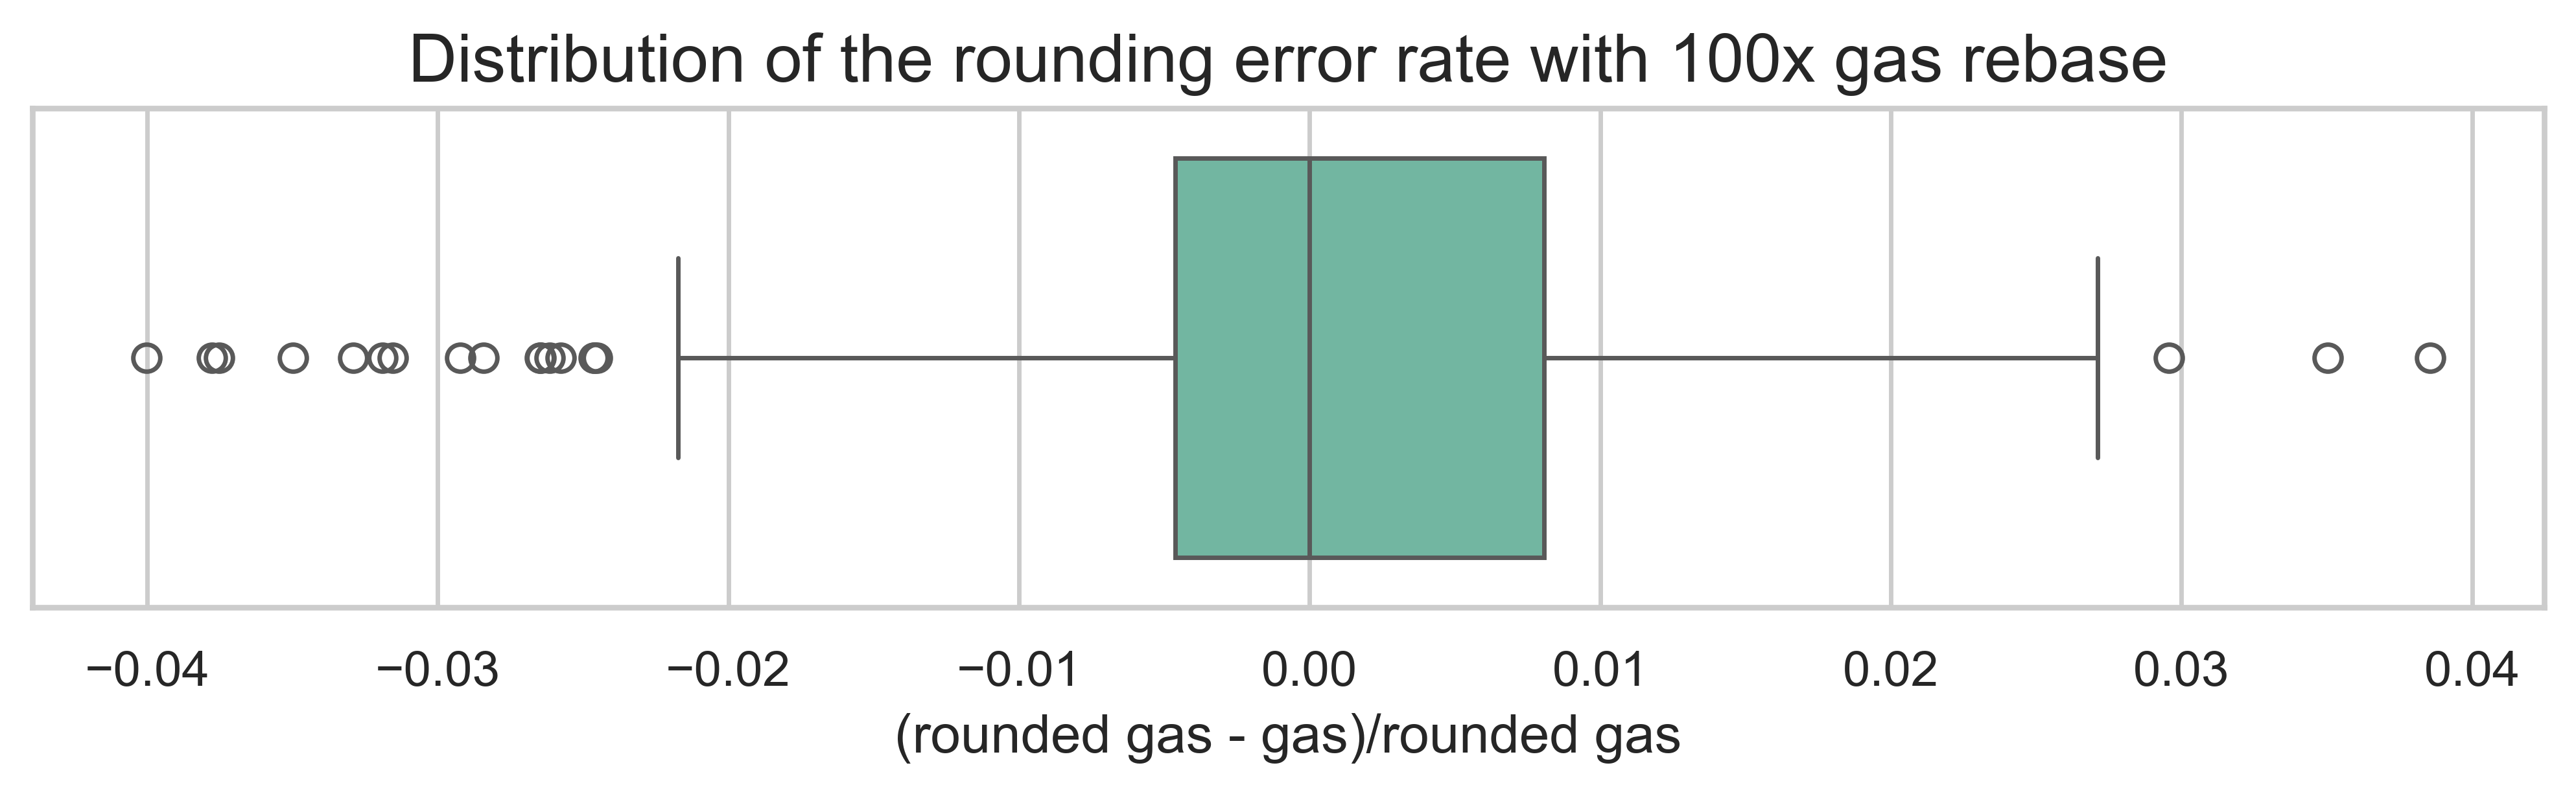

In [23]:
plt.figure(figsize=(10, 2))
sns.boxplot(
    data=new_gas_df,
    x="rounding_error_rate"
)

plt.title("Distribution of the rounding error rate with 100x gas rebase")
plt.ylabel("")
plt.xlabel("(rounded gas - gas)/rounded gas")
plt.show()

In [24]:
new_gas_df["rounding_error_rate"].agg(["mean", "std", "median"])

mean     -0.000235
std       0.015330
median   -0.000004
Name: rounding_error_rate, dtype: float64

Rounding error are must better now! However, this will certainly break a lot of hard-coded gas limits in contracts and tools...

## 50Mgas/s anchor with fractional gas (2 decimal places)

In [25]:
anchor_rate = 50*1e6

new_gas_df = worse_df.copy()
new_gas_df["new_gas"] = (anchor_rate*new_gas_df["param_ns"])/1e9
new_gas_df["new_gas_rounded"] = new_gas_df["new_gas"].round(2)
new_gas_df["new_gas_rounded"] = np.where(
    new_gas_df["new_gas_rounded"] == 0.0, 0.01, new_gas_df["new_gas_rounded"]
)
new_gas_df["rounding_error"] = new_gas_df["new_gas_rounded"] - new_gas_df["new_gas"]
new_gas_df["rounding_error_rate"] = new_gas_df["rounding_error"]/new_gas_df["new_gas_rounded"]
new_gas_df

,opcode,param_ns,new_gas,new_gas_rounded,rounding_error,rounding_error_rate
0,ADD,7.171282,0.358564,0.36,0.001436,0.003989
1,ADDMOD,25.502540,1.275127,1.28,0.004873,0.003807
2,ADDRESS,7.997121,0.399856,0.40,0.000144,0.000360
3,AND,3.857343,0.192867,0.19,-0.002867,-0.015090
4,BLAKE2F,258.113508,12.905675,12.91,0.004325,0.000335
...,...,...,...,...,...,...
130,SWAP9,5.524204,0.276210,0.28,0.003790,0.013535
131,TIMESTAMP,2.542497,0.127125,0.13,0.002875,0.022117
132,TLOAD,28.607564,1.430378,1.43,-0.000378,-0.000264
133,TSTORE,83.060644,4.153032,4.15,-0.003032,-0.000731


In [26]:
new_gas_df[new_gas_df["opcode"] == "ECRECOVER"]

,opcode,param_ns,new_gas,new_gas_rounded,rounding_error,rounding_error_rate
38,ECRECOVER,17191.023993,859.5512,859.55,-0.0012,-0.000001


In [27]:
new_gas_df[new_gas_df["opcode"] == "JUMPDEST"]

,opcode,param_ns,new_gas,new_gas_rounded,rounding_error,rounding_error_rate
48,JUMPDEST,1.741227,0.087061,0.09,0.002939,0.032652


Ok, let's see the distribution of rounding error rates per operation:

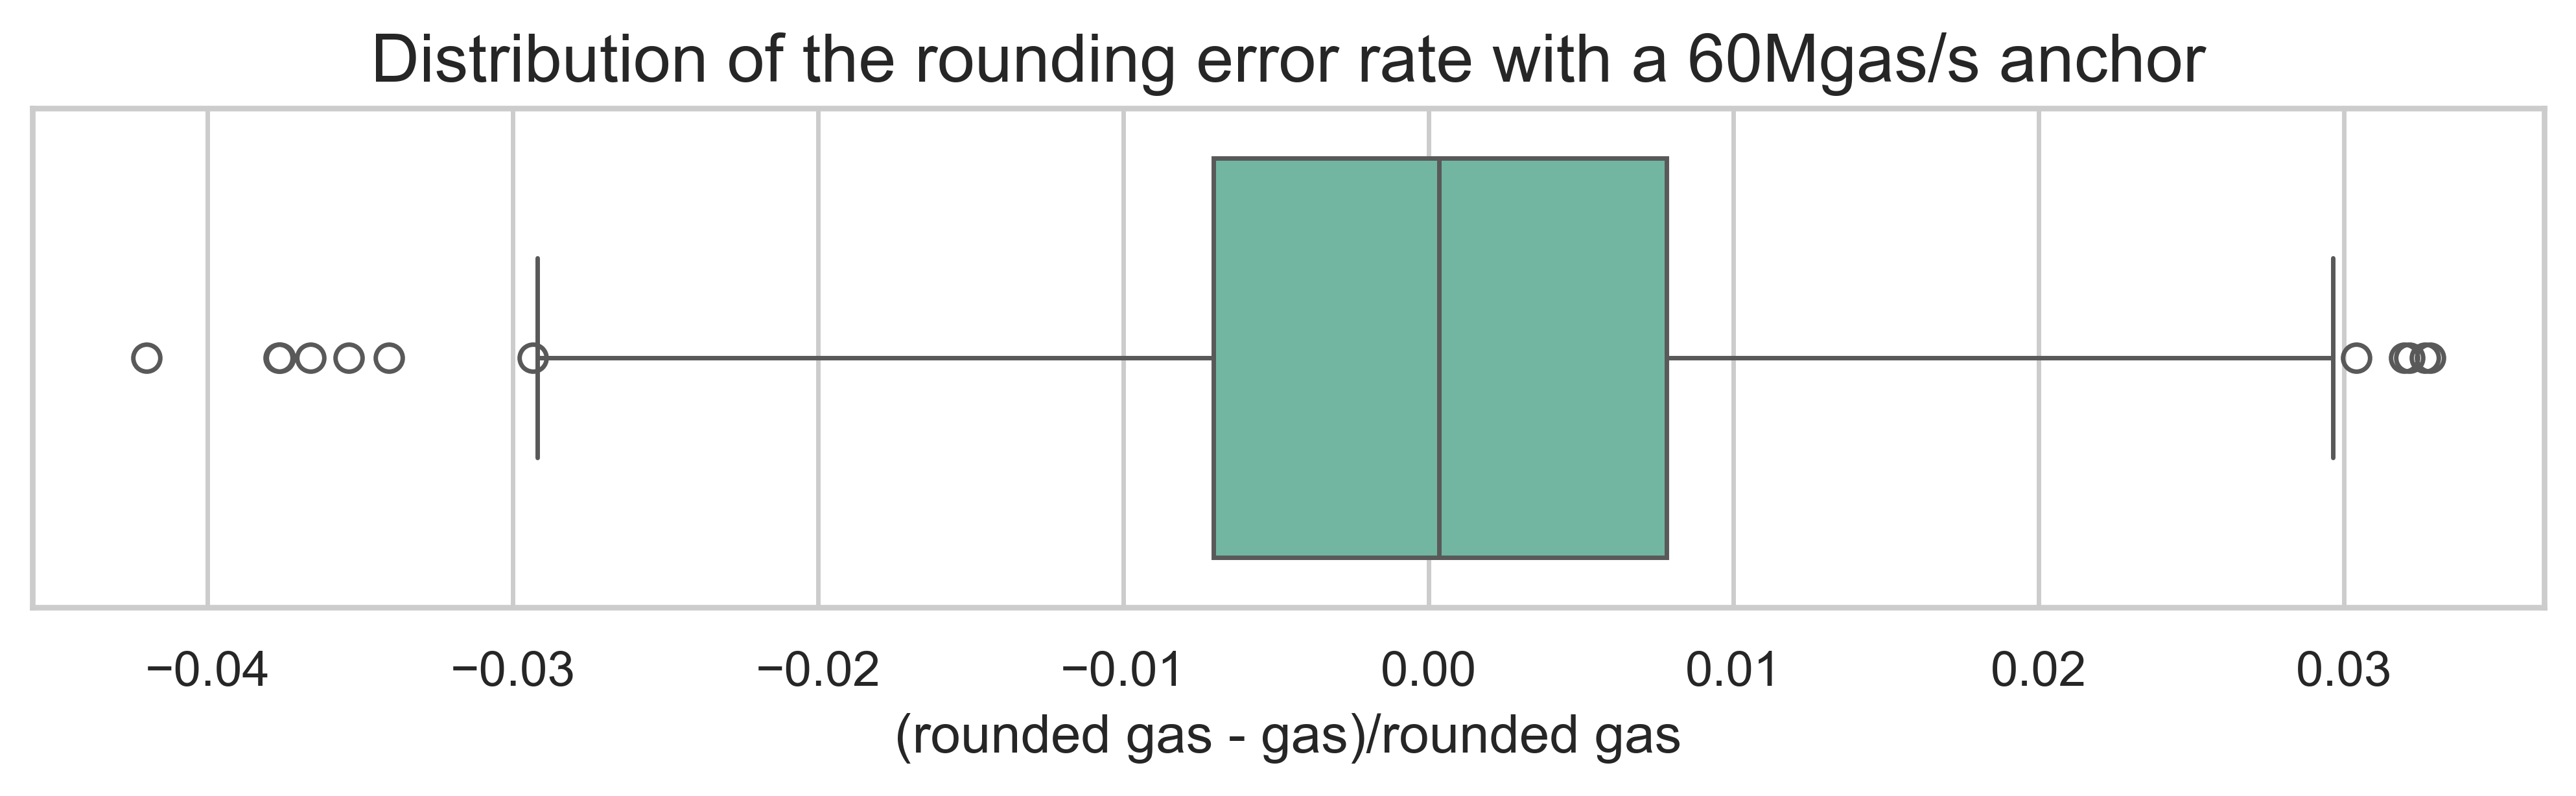

In [28]:
plt.figure(figsize=(10, 2))
sns.boxplot(
    data=new_gas_df,
    x="rounding_error_rate"
)

plt.title("Distribution of the rounding error rate with a 60Mgas/s anchor")
plt.ylabel("")
plt.xlabel("(rounded gas - gas)/rounded gas")
plt.show()

In [29]:
new_gas_df["rounding_error_rate"].agg(["mean", "std", "median"])

mean     -0.000078
std       0.015513
median    0.000360
Name: rounding_error_rate, dtype: float64